Code for Project 1 B.
To Use SVD instead of cv2.findHomography() set SVD to True
To Use findHomography() instead set SVD to False

In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

#Fix Plot Size
plt.rcParams["figure.figsize"]= (50,15)

DEBUG = False
SVD= True
TEST = False
alpha = 0.5
beta = (1-alpha)
sift = cv2.xfeatures2d.SIFT_create(nfeatures=1000)
bfm = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
TOP_MATCHES = 0.15


In [2]:
#Function to calculate Project Matrix P coupled with t
def calc_h_mat(srcPts, dstPts):

    # Construct Empty List
    p_list = []

    # Loop through selected Points
    for pt1, pt2 in zip(srcPts, dstPts):

        x = pt1[0][0]
        y = pt1[0][1]
        x_p = pt2[0][0]
        y_p = pt2[0][1]

        # From Lecture 2, hw 2.pdf Calculating homography
        p_list.append([x,y,1,0,0,0,-x_p*x,-x_p*y,-x_p])
        p_list.append([0,0,0,x,y,1,-y_p*x,-y_p*y,-y_p])
        
    p_mat = np.array(p_list)

    #Use svd to get H matrix
    u,s,vh = np.linalg.svd(p_mat)
    L = vh[-1,:]/vh[-1,-1]
    h_mat = L.reshape(3,3)

    return h_mat

In [3]:
def get_key_points(imgSrc,imgDst):
    
    srcGray = cv2.cvtColor(imgSrc,cv2.COLOR_BGR2GRAY)

    if DEBUG:
        plt.imshow(srcGray),plt.show()

    dstGray = cv2.cvtColor(imgDst,cv2.COLOR_BGR2GRAY)

    #Needed to Split up Detect & Compute as DetectAndCompute was crashing
    srcPts = sift.detect(srcGray,None)
    srcPts,srcDes = sift.compute(srcGray,srcPts)
    dstPts = sift.detect(dstGray,None)
    dstPts,dstDes = sift.compute(dstGray,dstPts)

    # Get Matches from Brute Froce knn
    matches = bfm.knnMatch(np.asarray(srcDes,np.float32),np.asarray(dstDes,np.float32),k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append(m)

    if len(good) > 3:
        cleaned_srcPts = np.float32([ srcPts[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        cleaned_dstPts = np.float32([ dstPts[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        return srcPts,dstPts,cleaned_srcPts,cleaned_dstPts,good
    else:
        print("Not Enough Matches!")
        exit()

In [4]:
#Main Function 
def main():
    
    # Load Images and Select Points
    img_center = cv2.imread('images/old_nemesis/img3.jpg')
    img_centerL = cv2.imread('images/old_nemesis/img2.jpg')
    img_centerR = cv2.imread('images/old_nemesis/img4.jpg')
    img_left = cv2.imread('images/old_nemesis/img1.jpg')
    img_right = cv2.imread('images/old_nemesis/img5.jpg')
    
    ### Segement for Matching Center Left to Center
    # Get All Keypoints, Good Keypoints, and Good Matches
    kp1,kp2,srcPts,dstPts,matches = get_key_points(img_centerL, img_center)

    # Determine Number of Points to Use for H Matrix Calculation
    numPts = int(len(matches)*TOP_MATCHES)
    
    if SVD:
        # Calculate P Matrix & H Matrix for centerLeft img to center img
        h_mat_cL2c = calc_h_mat(srcPts[:numPts], dstPts[:numPts])
        print('SVD H Matrix:\n')
        print(h_mat_cL2c)

    else:
        # Get H Matrix from cv2.findHomography()
        h_mat_cL2c,mask = cv2.findHomography(srcPts,dstPts, cv2.RANSAC,1.0)
        print("FindHomography H_mat\n")
        print(h_mat)
        matchesMask = mask.ravel().tolist()


    if DEBUG:
        # Visualize Matches 
        h = img_centerL.shape[1]
        w = img_centerL.shape[0]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,h_mat)
        img3 = cv2.polylines(img_center,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        img3 = cv2.drawMatches(img_centerL,kp1,img_center,kp2,matches,None,flags=2)
        plt.imshow(img3, 'gray'),plt.show()
        plt.clf(),plt.close('all')

    # Height & Width for Warped Perspective
    tmpSz = (5*img_centerL.shape[1],2*img_center.shape[0])

    w = 2*img_centerL.shape[1]
    h = int(1/4*img_centerL.shape[0])
    offset_mat = np.array([[1,0,w],[0,1,h],[0,0,1]],dtype=float)
    cLImg_warp = cv2.warpPerspective(img_centerL,offset_mat.dot(h_mat_cL2c),tmpSz)
    cImg_warp = cv2.warpPerspective(img_center,offset_mat,tmpSz)
    dstL = cv2.addWeighted(cLImg_warp,alpha,cImg_warp,beta,0.0)
    plt.imshow(dstL),plt.show()
    
    plt.clf(),plt.close('all')
    
    
    ### Segement for Matching Center Right to Center
    kp1,kp2,srcPts,dstPts,matches = get_key_points(img_centerR, img_center)
    numPts = int(len(matches)*TOP_MATCHES)

    if SVD:
        # Calculate H Matrix & H Matrix for centerLeft img to center img
        h_mat_cR2c = calc_h_mat(srcPts[:numPts], dstPts[:numPts])
        print('SVD H Matrix:\n')
        print(h_mat_cR2c)

    else:
        h_mat_cR2c,mask = cv2.findHomography(srcPts,dstPts, cv2.RANSAC,1.0)
        print("FindHomography H_mat\n")
        print(h_mat)
        matchesMask = mask.ravel().tolist()
    
    if DEBUG:
        h = img_centerR.shape[1]
        w = img_centerR.shape[0]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,h_mat)
        img3 = cv2.polylines(img_center,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        img3 = cv2.drawMatches(img_centerR,kp1,img_center,kp2,matches,None,flags=2)
        plt.imshow(img3, 'gray'),plt.show()
        plt.clf(),plt.close('all')


    cRImg_warp = cv2.warpPerspective(img_centerR,offset_mat.dot(h_mat_cR2c),tmpSz)
    dstR = cv2.addWeighted(dstL,alpha,cRImg_warp,beta,0.0)
    plt.imshow(dstR)
    plt.show()
    
    
    ### Segement for Matching Left Image to Center Left
    
    # Get points for Left to centerL
    kp1,kp2,srcPts,dstPts,matches = get_key_points(img_left, img_centerL)
    numPts = int(len(matches)*TOP_MATCHES)

    if SVD:
        # Calculate P Matrix & H Matrix for Left to centerLeft img 
        h_mat_L2cL = calc_h_mat(srcPts[:numPts], dstPts[:numPts])
        print('SVD H Matrix:\n')
        print(h_mat_L2cL)
        h_mat_L2cL,mask = cv2.findHomography(srcPts,dstPts, cv2.RANSAC,1.0)
    else:
        h_mat_L2cL,mask = cv2.findHomography(srcPts,dstPts, cv2.RANSAC,1.0)
        print("FindHomography H_mat\n")
        print(h_mat)
    
    if DEBUG:
        matchesMask = mask.ravel().tolist()
        h = img_left.shape[1]
        w = img_left.shape[0]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,h_mat)
        img3 = cv2.polylines(img_centerL,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        img3 = cv2.drawMatches(img_left,kp1,img_centerL,kp2,matches,None,flags=2)
        plt.imshow(img3, 'gray'),plt.show()
        plt.clf(),plt.close('all')

    lImg_warp = cv2.warpPerspective(img_left,offset_mat.dot(h_mat_L2cL.dot(h_mat_cL2c)),tmpSz)
    dstLR = cv2.addWeighted(dstR,alpha,lImg_warp,beta,0.0)
    plt.imshow(dstLR)
    plt.show()
    
    
    ### Segement for Matching Right Image to Center Right Image
    
    # Get points for Right to centerR
    kp1,kp2,srcPts,dstPts,matches = get_key_points(img_right, img_centerR)
    numPts = int(len(matches)*TOP_MATCHES)
    
    if SVD:
        # Calculate P Matrix & H Matrix for Right to centerRight img 
        h_mat_R2cR = calc_h_mat(srcPts[:numPts], dstPts[:numPts])
        print('SVD H Matrix:\n')
        print(h_mat_R2cR)

    else:
        h_mat_R2cR,mask = cv2.findHomography(srcPts,dstPts, cv2.RANSAC,1.0)
        print("FindHomography H_mat\n")
        print(h_mat) 
    
    if DEBUG:
        matchesMask = mask.ravel().tolist()
        h = img_right.shape[1]
        w = img_right.shape[0]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,h_mat)
        img3 = cv2.polylines(img_centerR,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        img3 = cv2.drawMatches(img_right,kp1,img_centerR,kp2,matches,None,flags=2)
        plt.imshow(img3, 'gray'),plt.show()
        plt.clf(),plt.close('all')

    rImg_warp = cv2.warpPerspective(img_right,offset_mat.dot(h_mat_R2cR.dot(h_mat_cR2c)),tmpSz)
       
    dstT = cv2.addWeighted(dstLR,alpha,rImg_warp,beta,0.0)
    
    # Clean up color contrast problem
    dstT_copy = dstT.copy()
    
    # Get Mask
    warp_mask = np.any(dstLR !=[0,0,0], axis=-1)
    dstT_copy[warp_mask] = dstLR[warp_mask]
    dstT2 = cv2.addWeighted(dstT,1,dstT_copy,1,0.0)
    plt.imshow(dstT2)
    plt.show()

SVD H Matrix:

[[ 1.06180895e+00  6.89744620e-03 -1.44771960e+03]
 [ 6.61840973e-02  1.09995382e+00 -3.31596558e+02]
 [ 2.06291473e-05  1.45538169e-05  1.00000000e+00]]


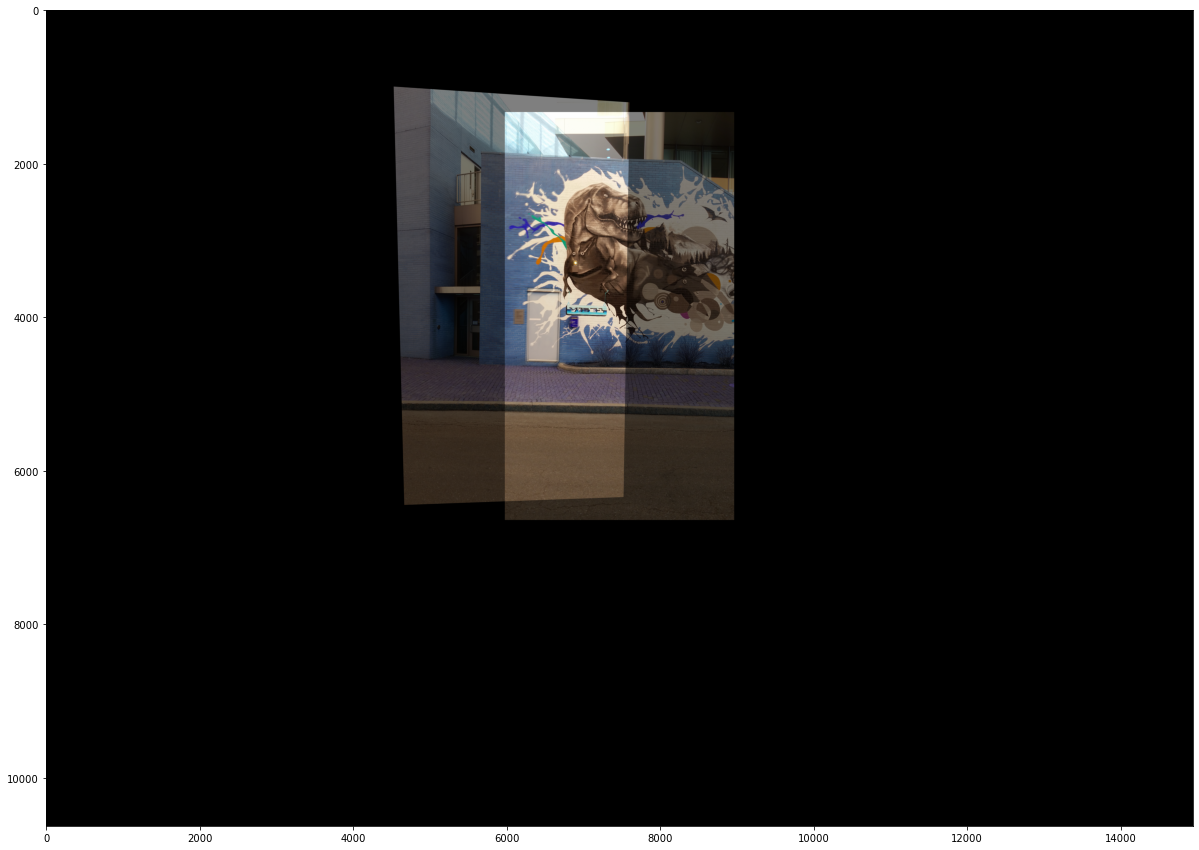

SVD H Matrix:

[[ 9.85926344e-01 -2.34305757e-02  1.47026845e+03]
 [-2.05688257e-02  9.84298867e-01  2.25369594e+02]
 [-5.28451881e-06 -1.24769818e-07  1.00000000e+00]]


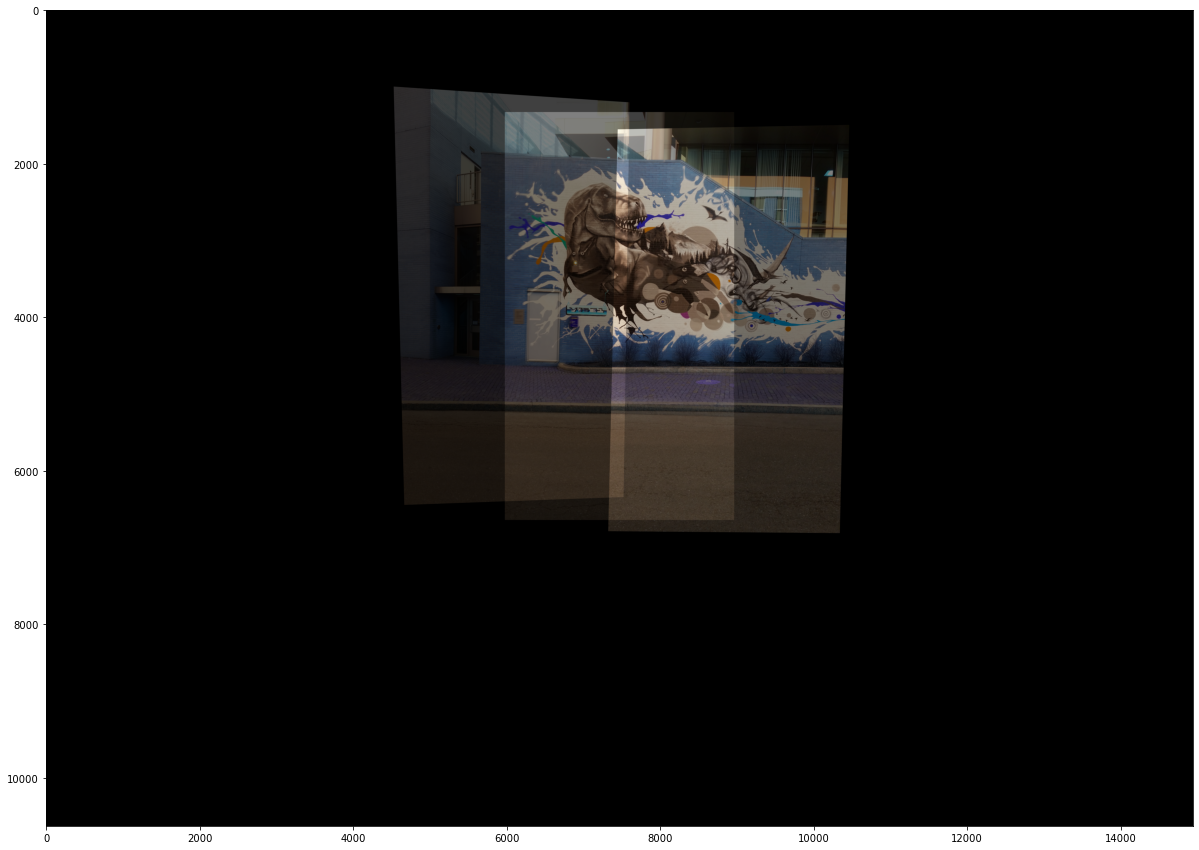

SVD H Matrix:

[[ 2.23727332e-01  7.22680521e-02  4.67420718e+02]
 [-4.74439120e-01  6.79508093e-01  1.04328161e+03]
 [-1.96253171e-04  3.83795207e-05  1.00000000e+00]]


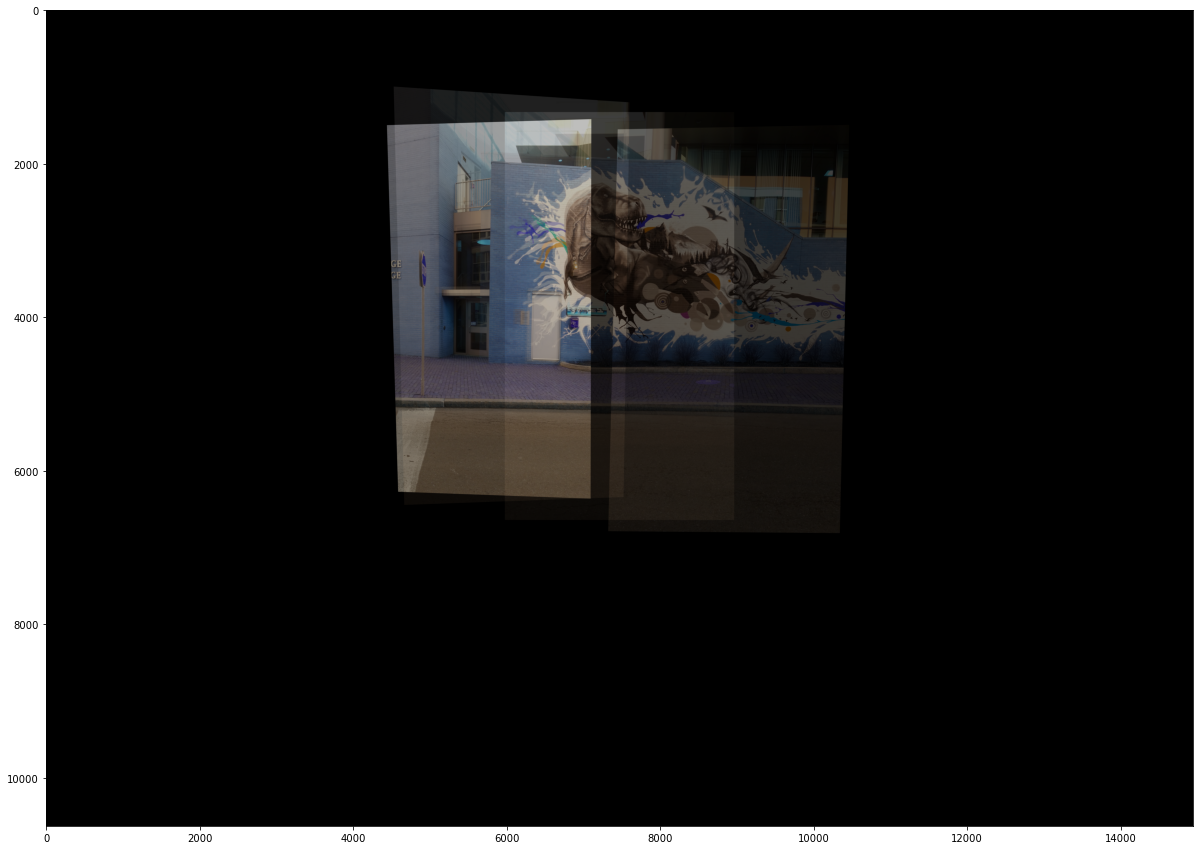

SVD H Matrix:

[[ 8.90885707e-01 -3.89308732e-02  1.78789361e+03]
 [-1.01395209e-01  9.61537406e-01  2.00074951e+02]
 [-3.75496643e-05 -3.87695333e-06  1.00000000e+00]]


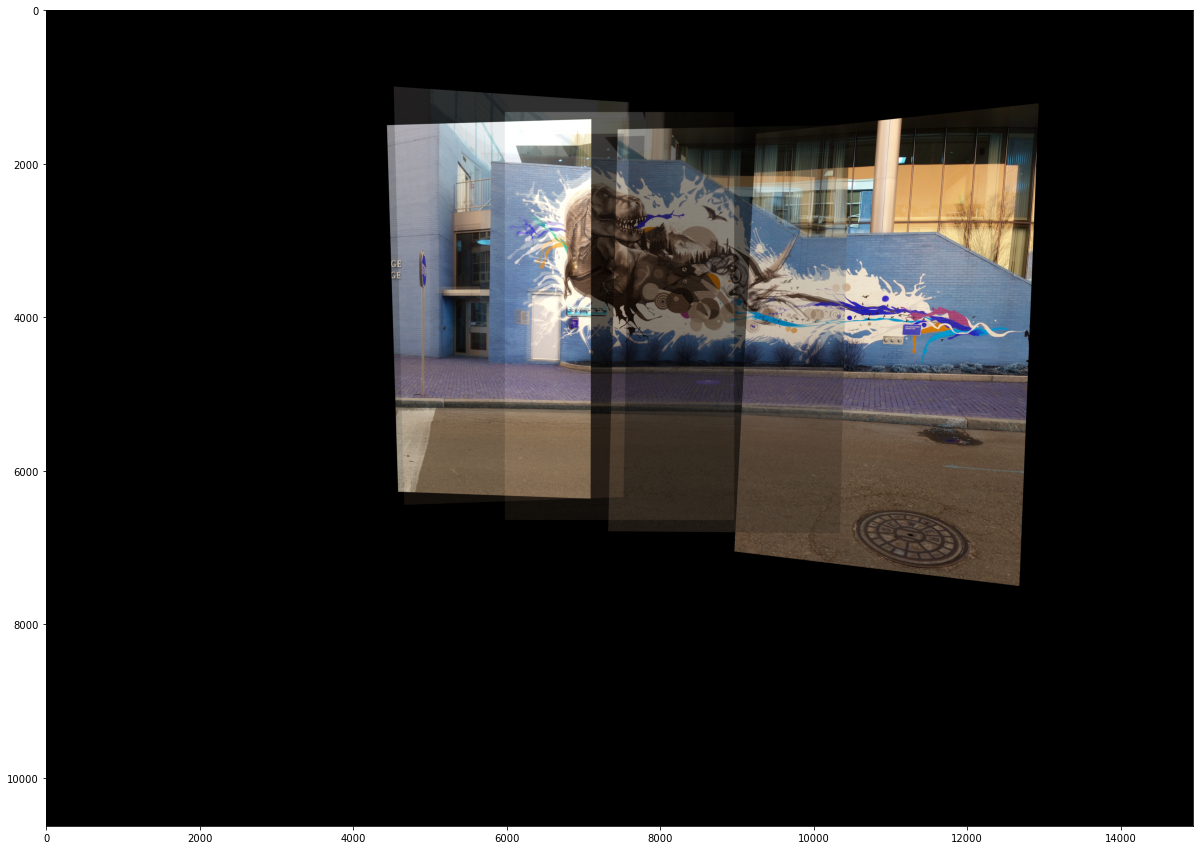

In [5]:
if __name__=="__main__":
    main()